<h1> Time series prediction using RNNs, with TensorFlow and Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.contrib.learn 
<li> Training on Cloud ML Engine
</ol>

<p>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [ ]:
!pip install --upgrade tensorflow

In [1]:
import tensorflow as tf
print tf.__version__

1.7.0


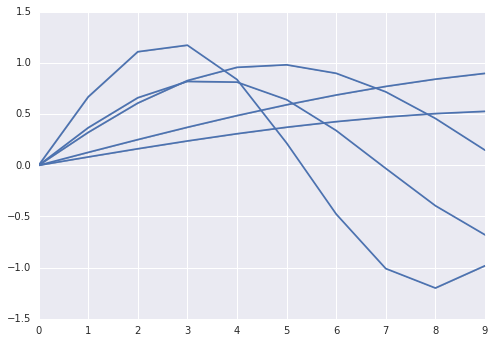

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd

SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

for i in xrange(0, 5):
  sns.tsplot( create_time_series() );  # 5 series

In [3]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in xrange(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [ ]:
!head -5 train.csv valid.csv

<h2> RNN </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

Here, we are trying to predict from 8 values of a timeseries, the next two values.

<p>

<h3> Imports </h3>

Several tensorflow packages and shutil

In [5]:
import tensorflow as tf
import shutil
from tensorflow.contrib.learn import ModeKeys
import tensorflow.contrib.rnn as rnn

<h3> Input Fn to read CSV </h3>

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.  The Estimator API in tf.contrib.learn wants the features returned as a dict. We'll just call this timeseries column 'rawdata'.
<p>
Our CSV file sequences consist of 10 numbers. We'll assume that 8 of them are inputs and we need to predict the next two.

In [6]:
DEFAULTS = [[0.0] for x in xrange(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

Reading data using the Estimator API in tf.learn requires an input_fn. This input_fn needs to return a dict of features and the corresponding labels.
<p>
So, we read the CSV file.  The Tensor format here will be batchsize x 1 -- entire line.  We then decode the CSV. At this point, all_data will contain a list of Tensors. Each tensor has a shape batchsize x 1.  There will be 10 of these tensors, since SEQ_LEN is 10.
<p>
We split these 10 into 8 and 2 (N_OUTPUTS is 2).  Put the 8 into a dict, call it features.  The other 2 are the ground truth, so labels.

In [7]:
# read data and convert to needed format
def read_dataset(filename, mode=ModeKeys.TRAIN):
  def _input_fn():
    num_epochs = 100 if mode == ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    

    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    value_column = tf.expand_dims(value, -1, name='value')
    print('readcsv={}'.format(value_column))
    
    # all_data is a list of tensors
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
    inputs = all_data[:len(all_data)-N_OUTPUTS]  # first few values
    label = all_data[len(all_data)-N_OUTPUTS : ] # last few values
    
    # from list of tensors to tensor with one more dimension
    inputs = tf.concat(inputs, axis=1)
    label = tf.concat(label, axis=1)
    print('inputs={}'.format(inputs))

    return {TIMESERIES_COL: inputs}, label   # dict of features, label

  return _input_fn

<h3> Define RNN </h3>

A recursive neural network consists of possibly stacked LSTM cells.
<p>
The RNN has one output per input, so it will have 8 output cells.  We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).
<p>
Finally, to supply a model function to the Estimator API, you need to return a ModelFnOps. The rest of the function creates the necessary objects.

In [19]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, labels, mode, params):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
  #print 'x={}'.format(x)
    
  # 1. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

  # slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  #print 'last outputs={}'.format(outputs)
  
  # output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. loss function, training/eval ops
  if mode == ModeKeys.TRAIN or mode == ModeKeys.EVAL:
     loss = tf.losses.mean_squared_error(labels, predictions)
     train_op = tf.contrib.layers.optimize_loss(
         loss=loss,
         global_step=tf.train.get_global_step(),
         learning_rate=0.01,
         optimizer="SGD")
     eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
     }
  else:
     loss = None
     train_op = None
     eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}

  # 4. Create export outputs  
  export_outputs = {"predicted": tf.estimator.export.PredictOutput(predictions)}

  # 5. return ModelFnOps
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs=export_outputs)

<h3> Experiment </h3>

Distributed training is launched off using an Experiment.  The key line here is that we use tflearn.Estimator rather than, say tflearn.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time.

In [ ]:
def get_train():
  return read_dataset('train.csv', mode=ModeKeys.TRAIN)

def get_valid():
  return read_dataset('valid.csv', mode=ModeKeys.EVAL)

def serving_input_receiver_fn():
  feature_placeholders = {
    TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }

  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }

  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2], name='timeseries')
  
  print('serving: features={}'.format(features[TIMESERIES_COL]))

  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)


def experiment_fn(output_dir):
  train_spec = tf.estimator.TrainSpec(input_fn=get_train(), max_steps=1000)
  exporter = tf.estimator.FinalExporter('timeseries',
    serving_input_receiver_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn=get_valid(), 
    exporters=[exporter])

  estimator = tf.estimator.Estimator(model_fn=simple_rnn, model_dir=output_dir)

  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

OUTPUT_DIR = 'outputdir'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True) # start fresh each time

experiment_fn(OUTPUT_DIR)

<h3> Standalone Python module </h3>

To train this on Cloud ML Engine, we take the code in this notebook, make an standalone Python module.

In [ ]:
%bash
# run module as-is
REPO=$(pwd)
echo $REPO
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${REPO}/simplernn
python -m trainer.task \
   --train_data_paths="${REPO}/train.csv*" \
   --eval_data_paths="${REPO}/valid.csv*"  \
   --output_dir=${REPO}/outputdir \
   --job-dir=./tmp

Try out online prediction.  This is how the REST API will work after you train on Cloud ML Engine

In [ ]:
%writefile test.json
{"rawdata": [0.0,0.0527,0.10498,0.1561,0.2056,0.253,0.2978,0.3395]}

In [41]:
%bash
MODEL_DIR=$(ls ./outputdir/export/Servo/)
gcloud ml-engine local predict --model-dir=./outputdir/export/Servo/$MODEL_DIR --json-instances=test.json

predictions:
- predicted:
  - 0.456365
  - 0.48135


2017-06-27 17:52:12.098577: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-06-27 17:52:12.098596: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.



<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine.

In [ ]:
%bash
# run module on Cloud ML Engine
REPO=$(pwd)
BUCKET=cloud-training-demos-ml # CHANGE AS NEEDED
OUTDIR=gs://${BUCKET}/simplernn/model_trained
JOBNAME=simplernn_$(date -u +%y%m%d_%H%M%S)
REGION=us-central1
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${REPO}/simplernn/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.2 \
   -- \
   --train_data_paths="gs://${BUCKET}/train.csv*" \
   --eval_data_paths="gs://${BUCKET}/valid.csv*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

<h2> Variant: long sequence </h2>

To create short sequences from a very long sequence.

In [10]:
import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in xrange(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print 'input=', x.eval()
    seqx = breakup(sess, x, 5)
    print 'output=', seqx.eval()

input= [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
output= [[ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]]


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License